In [73]:
import numpy as np
from scipy.signal import savgol_filter
from math import ceil
from scipy.signal import csd
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')



class noise(object):
    
    
    def __init__(self, traces, sampleRate, channNames, traceGain = 1.0, name = None, freqs = None, time = None \
                 , PSD = None , real_PSD = None, imag_PSD = None, corrCoeff = None, unCorrNoise = None \
                 , corrNoise = None, real_CSD = None, imag_CSD = None, real_CSD_std = None, imag_CSD_std = None):
        self.traces = traces # 3d numpy array. dimention zero is number of traces, d-1 is channel number, 
        #d-3 is number of data points per trace
        self.sampleRate = sampleRate
        self.channNames = channNames
        self.time = time # array of x-values in units of time [sec]
        self.name = name
        
         #list of channel names
        self.traceGain = traceGain #convertion of trace amplitude from ADC bins to amperes 
        self.freqs = freqs
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        self.corrCoeff = corrCoeff
        self.unCorrNoise = unCorrNoise
        self.corrNoise = corrNoise
        self.real_CSD = real_CSD
        self.imag_CSD = imag_CSD
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
        
        
        
        
    
    def set_freqs(self, freqs):
        self.freqs = freqs
    def set_traceGain(self, traceGain):
        self.traceGain = traceGain
    def set_sampleRate(self, sampleRate):
        self.sampleRate = sampleRate
    def set_channNames(self, channNames):
        self.channNames = channNames
    def set_name(self, name):
        self.name = name
        
        
    
        
        
    def calculate_freqs(self):
        dt = 1/self.sampleRate
        self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = dt)

    
    def caclulate_PSD(self): 
        # get shape of traces to use for iterating
        traceShape = self.traces.shape
        #check if length of individual trace is odd of even
        if traceShape[2] % 2 != 0:
            lenPSD = int((traceShape[2] + 1)/2)
        else:
            lenPSD = int(traceShape[2]/2 + 1)
            
        # initialize empty numpy array to hold the PSDs 
        PSD = np.empty(shape = (traceShape[1], lenPSD))
        real_PSD = np.empty(shape = (traceShape[1], lenPSD))
        imag_PSD = np.empty(shape = (traceShape[1], lenPSD))
               
        for ichan in range(traceShape[1]):

            fft = np.fft.rfft(self.traces[:,ichan,:])
            PSD_chan = np.abs(fft)**2
            real_PSD_chan = np.real(fft)**2
            imag_PSD_chan = np.imag(fft)**2
                
            # take the average of the PSD's for each trace, normalize, and fold over the 
            # negative frequencies since they are symmetric
            PSD[ichan] = np.mean(PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate) 
            real_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
            imag_PSD[ichan] = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        
    def calculate_corrCoeff(self):
        nsizeMatrix = self.traces.shape[1]
        if self.traces.shape[2] % 2 != 0:
            lenPSD = int((self.traces.shape[2] + 1)/2)
        else:
            lenPSD = int(self.traces.shape[2]/2 + 1)
                
        nDataPoints = self.traces.shape[0]
                                
        #corr_coeff = np.zeros(shape=(nsizeMatrix,nsizeMatrix,lenPSD),dtype = np.float64)              
        traces_fft_chan = np.empty(shape = (nsizeMatrix,nDataPoints, lenPSD))        
        corr_coeff = np.empty(shape=(lenPSD,nsizeMatrix,nsizeMatrix)) 
        
        #for ichan in range(nsizeMatrix):       
        #    traces_fft_chan[ichan] = np.abs(np.fft.rfft(traces[:,ichan,:]))**2
        traces_fft_chan = np.abs(np.fft.rfft(traces))**2
        traces_fft_chan = np.swapaxes(traces_fft_chan, 0,1)
        for n in range(lenPSD):
            corr_coeff[n] = np.corrcoef(traces_fft_chan[:,:,n])
        
        self.corrCoeff = np.swapaxes(corr_coeff, 0, 2)
        
        
    
        
    ############# plotting
    def plot_PSD(self, lgc_overlay = True, lgcSave = False, savePath = None):
        '''
        Function to plot the noise spectrum referenced to the TES line in units of Amperes/sqrt(Hz)
        
        Input parameters:
        lgc_overlay: boolian value. If True, PSD's for all channels are overlayed in a single plot, 
                     if False, each PSD for each channel is plotted in a seperate subplot
        lgcSave: boolian value. If True, the figure is saved in the user provided directory
        savePath: absolute path for the figure to be saved
        
        Returns:
        None
        '''
        
        
        
        if lgc_overlay:
            sns.set_context('notebook')
            plt.figure()
            plt.xlabel('frequency [Hz]')
            plt.ylabel(r'Input Referenced Noise [A/$\sqrt{\mathrm{Hz}}$]')
            plt.grid(which = 'both')
            for ichan, channel in enumerate(self.channNames):
                plt.loglog(self.freqs[1:], np.sqrt(self.PSD[ichan][1:]), label = channel)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_PSD_overlay.png')
                except:
                    print('Invalid save path. Figure not saved')
            
    
    
        else:
            sns.set_context('poster', font_scale = 1.9)
            num_subplots = len(self.channNames)
            nRows = int(ceil(num_subplots/2))
            nColumns = 2

            fig, axes = plt.subplots(nRows, nColumns, figsize = (6*num_subplots,6*num_subplots)) 
            plt.suptitle(self.name,  fontsize=40)
            for ii in range(nRows*2):
                if ii < 4:
                    iRow = ii
                    jColumn = 0
                else:
                    iRow = ii - 4
                    jColumn = 1
                if ii < num_subplots:    
                    axes[iRow,jColumn].set_title(self.channNames[ii])
                    axes[iRow,jColumn].set_xlabel('frequency [Hz]')
                    axes[iRow,jColumn].set_ylabel(r'Input Referenced Noise [A/$\sqrt{\mathrm{Hz}}$]')
                    axes[iRow,jColumn].grid(which = 'both')
                    axes[iRow,jColumn].loglog(self.freqs[1:], np.sqrt(self.PSD[ii][1:]))
                else:
                    axes[iRow,jColumn].axis('off')


            plt.tight_layout() 
            plt.subplots_adjust(top=0.95)
            plt.show()

            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_PSD_subplot.png')
                except:
                    print('Invalid save path. Figure not saved')
            
    def plot_corrCoef(self, lgcSave = False, savePath = None):
        '''
        Function to plot the cross channel correlation coefficients. Since there is typically few traces,
        the correlations are often noisy. a savgol_filter is used to smooth out some of the noise
        
        Input parameters:
        lgcSave: boolian value. If True, the figure is saved in the user provided directory
        savePath: absolute path for the figure to be saved
        
        Returns:
        None
        '''
        sns.set_context('notebook')
        plt.figure()
        plt.title('{} \n Cross Channel Correlation Coefficients'.format(self.name) )
        for ii in range(self.corrCoeff.shape[0]):
            for jj in range(self.corrCoeff.shape[1]):
                if ii > jj:
                    label = '{} - {}'.format(self.channNames[ii],self.channNames[jj])
                    plt.plot(self.freqs, savgol_filter(self.corrCoeff[ii][jj], 51,3), label = label, alpha = .5)
                    plt.xscale('log')
        plt.xlabel('frequency [Hz]')
        plt.ylabel(r'Correlation Coeff [COV(x,y)/$\sigma_x \sigma_y$]')
        plt.grid(which = 'both')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_corrCoeff.png')
                except:
                    print('Invalid save path. Figure not saved')
            
######################### decorrelation of noise ##########
    def calculate_CSD(self):
        traceShape = self.traces.shape
        nsizeMatrix = traceShape[1]
        nfft = traceShape[2]
        nTraces = traceShape[0]

        if traceShape[2] % 2 != 0:
            nFreqs = int((traceShape[2] + 1)/2)
        else:
            nFreqs = int(traceShape[2]/2 + 1)
          
                           
        # initialize the S_ij matrix
        real_CSD_traces = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nTraces,nFreqs),dtype = np.float64)
        imag_CSD_traces = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nTraces,nFreqs),dtype = np.float64)
        
        real_CSD_mean = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nFreqs),dtype = np.float64)
        imag_CSD_mean = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nFreqs),dtype = np.float64)
        
        real_CSD_std = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nFreqs),dtype = np.float64)
        imag_CSD_std = np.zeros(shape=(nsizeMatrix,nsizeMatrix,nFreqs),dtype = np.float64)
            
        for iRow, jColumn in combinations(range(nsizeMatrix),2):
            for n in range(nTraces):
                freqs ,temp_CSD = csd(self.traces[n,iRow,:],self.traces[n,jColumn,:] \
                                           , nperseg = nfft, fs = self.sampleRate, nfft = nfft )            
                real_CSD_traces[iRow][jColumn][n] = np.real(temp_CSD) 
                imag_CSD_traces[iRow][jColumn][n] = np.imag(temp_CSD) 
                
            real_CSD_mean[iRow][jColumn] = np.mean(real_CSD_traces[iRow][jColumn],axis = 0)
            imag_CSD_mean[iRow][jColumn] = np.mean(imag_CSD_traces[iRow][jColumn],axis = 0)    
            real_CSD_std[iRow][jColumn] = np.std(real_CSD_traces[iRow][jColumn],axis = 0)
            imag_CSD_std[iRow][jColumn] = np.std(imag_CSD_traces[iRow][jColumn],axis = 0)
        
          
        
    
        self.real_CSD = real_CSD_mean
        self.imag_CSD = imag_CSD_mean
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

### Load test traces

In [6]:

import pickle as pkl    
with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', "rb") as f:
        traces = pkl.load(f,fix_imports=True,encoding='latin1')

### Initialize noise object

In [74]:
sampleRate = 625e3
channels = [ 'PCS1' , 'PES1' , 'PFS1' , 'PAS2' , 'PBS2' , 'PES2' , 'PDS2' ]
g124_noise = noise(traces, sampleRate, channels)
g124_noise.set_name('G124 SLAC Run 37 Pulse Tube On')


### Calculate PSD and correlation coefficients

In [75]:

g124_noise.calculate_freqs()
g124_noise.caclulate_PSD()
g124_noise.calculate_corrCoeff()

### Test calculation of Cross Spectral Density

In [79]:
%timeit g124_noise.calculate_CSD()

1 loop, best of 3: 3.6 s per loop


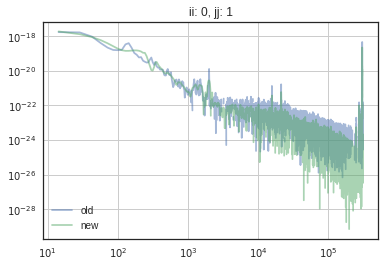

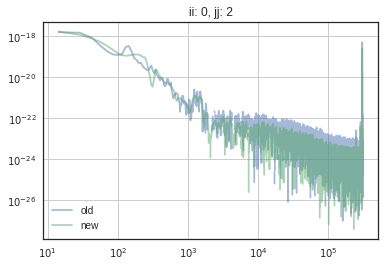

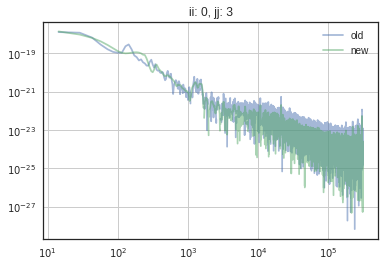

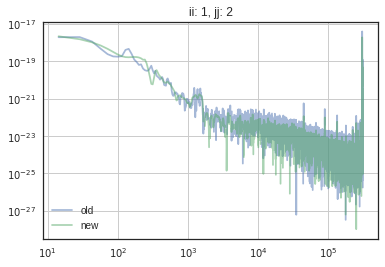

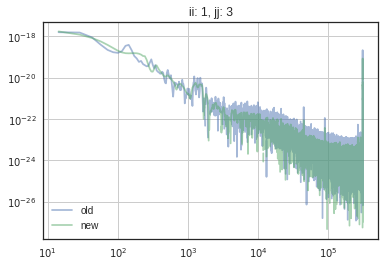

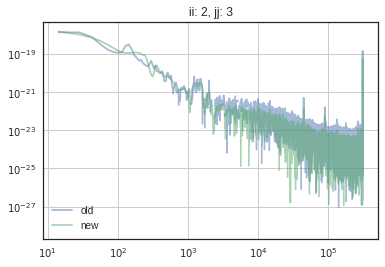

In [100]:
#old = g124_noise.real_CSD
for ii in range(old.shape[0] - 3 ):
    for jj in range(old.shape[1] - 3):
        if ii < jj:
            plt.figure()
            plt.title('ii: {}, jj: {}'.format(ii,jj))
            plt.loglog(g124_noise.freqs[1:],(old[ii][jj][1:]).clip(0), label = 'old', alpha = .5)
            plt.loglog(g124_noise.freqs[1:], savgol_filter((g124_noise.real_CSD[ii][jj][1:]).clip(0),31,5), label = 'new', alpha = .5)
            plt.grid()
            plt.legend()



### Test Plotting of PSD and correlation coefficients

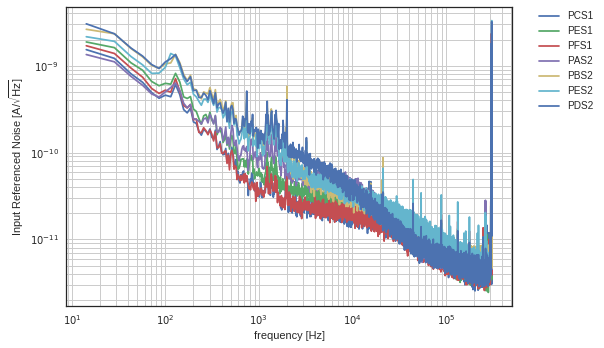

In [9]:
g124_noise.plot_PSD(lgc_overlay=True)

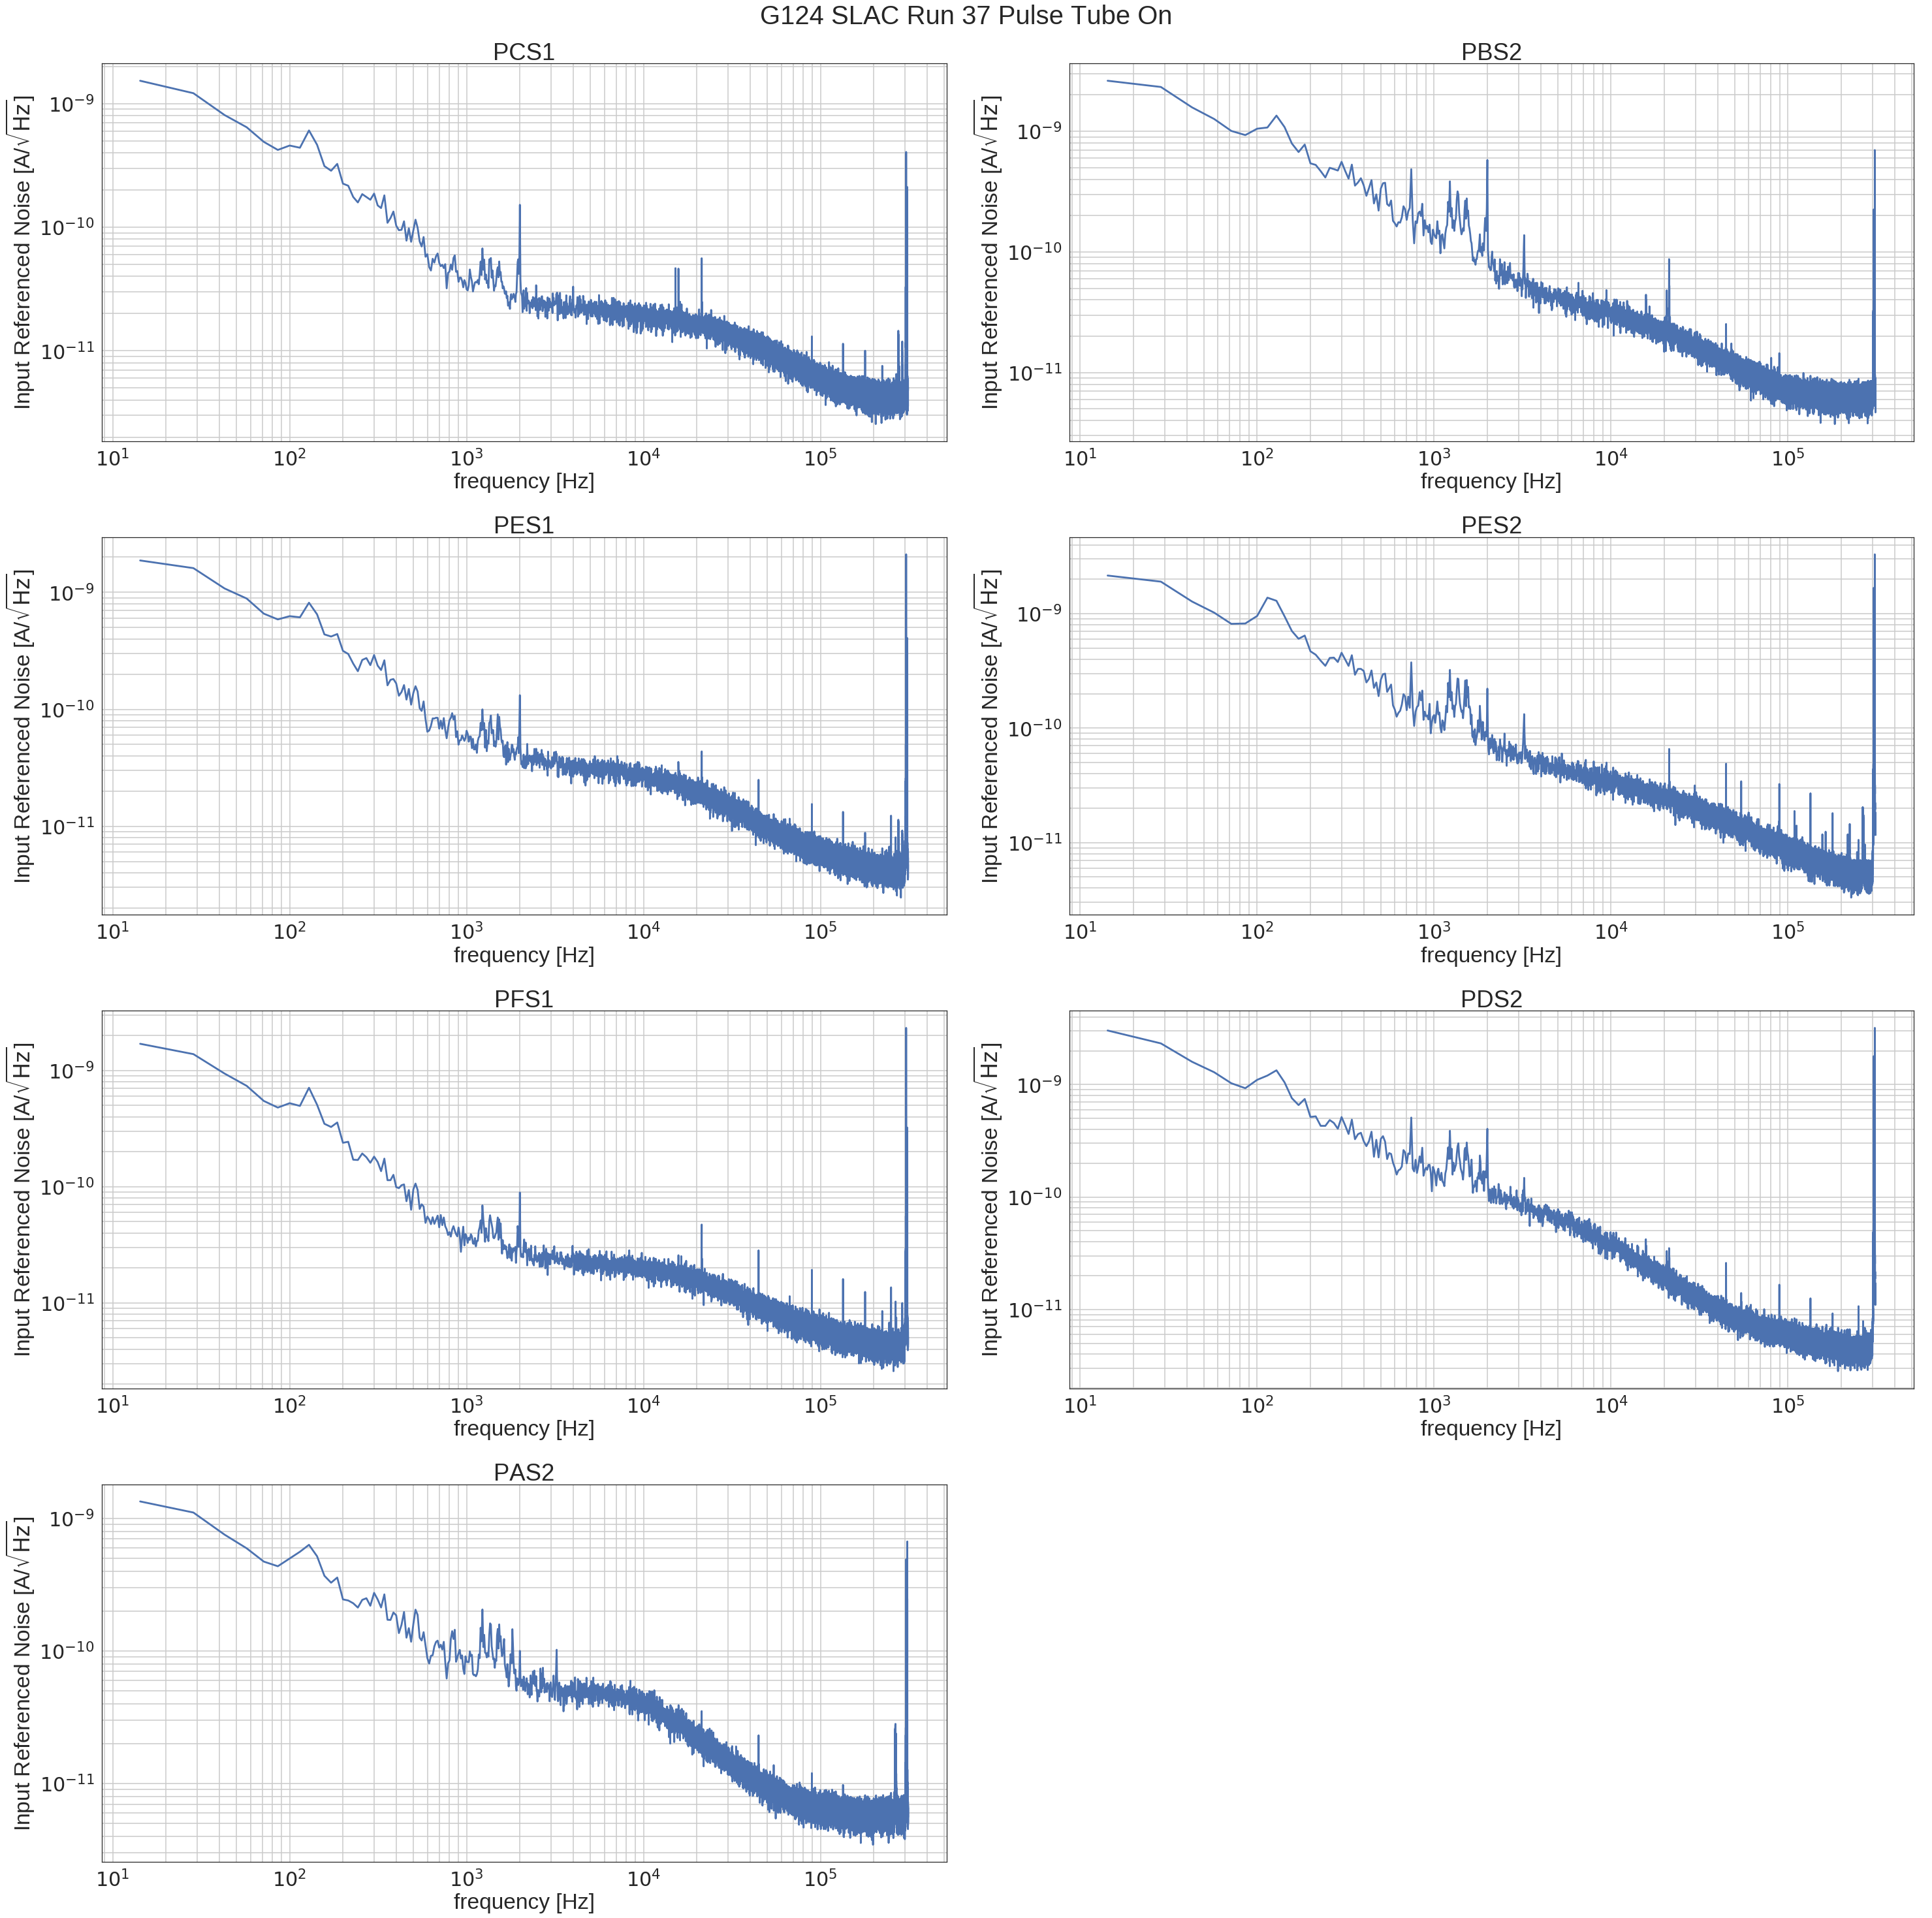

In [10]:
g124_noise.plot_PSD(lgc_overlay=False)


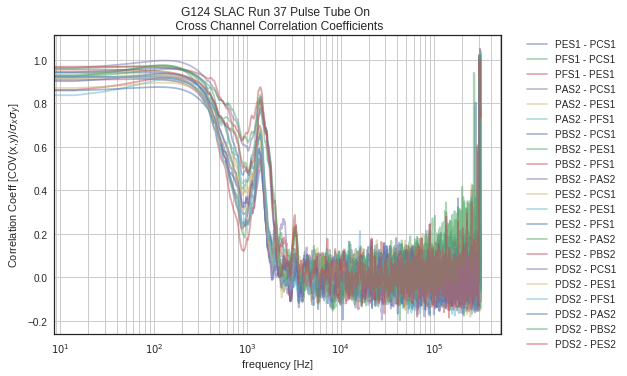

In [11]:
g124_noise.plot_corrCoef()